In [ ]:
%matplotlib inline


Transfer Learning for Classifying Paintings
==============================================
**Original Transfer Learning Tutorial by:** `Sasank Chilamkurthy <https://chsasank.github.io>`_
You can read more about the transfer learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

I have modified the original code to work on 5 classes and experimented with different architectures.

Quoting these notes,
    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use a dataset that contains 500 training images and 100 test images of 5 different art movements.

## Get Data From Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### If data is not processed into folders correctly

In [ ]:
!cp drive/MyDrive/machineLearning/yz_resim500.zip ./

In [ ]:
!unzip ./yz_resim500.zip
!rm ./readme.txt

In [ ]:
!mkdir ./data/

!mkdir data/train
!mkdir data/test
!mkdir data/val

!mkdir data/train/baroque
!mkdir data/train/postimp
!mkdir data/train/renaiss
!mkdir data/train/surreal
!mkdir data/train/express

!mkdir data/val/baroque
!mkdir data/val/postimp
!mkdir data/val/renaiss
!mkdir data/val/surreal
!mkdir data/val/express

!mkdir data/test/baroque
!mkdir data/test/postimp
!mkdir data/test/renaiss
!mkdir data/test/surreal
!mkdir data/test/express


In [ ]:
#Train: 0.8, Validation: 0.15, Test: 0.05
!shuf -n 80 -e ./Baroque/* | xargs -i mv {} data/train/baroque
!shuf -n 80 -e ./Post_Impressionism/* | xargs -i mv {} data/train/postimp
!shuf -n 80 -e ./Renaissance/* | xargs -i mv {} data/train/renaiss
!shuf -n 80 -e ./Surrealism/* | xargs -i mv {} data/train/surreal
!shuf -n 80 -e ./Expressionism/* | xargs -i mv {} data/train/express

!shuf -n 20 -e ./Baroque/* | xargs -i mv {} data/val/baroque
!shuf -n 20 -e ./Post_Impressionism/* | xargs -i mv {} data/val/postimp
!shuf -n 20 -e ./Renaissance/* | xargs -i mv {} data/val/renaiss
!shuf -n 20 -e ./Surrealism/* | xargs -i mv {} data/val/surreal
!shuf -n 20 -e ./Expressionism/* | xargs -i mv {} data/val/express

'''
!shuf -n 15 -e ./Baroque/* | xargs -i mv {} data/val/baroque
!shuf -n 15 -e ./Post_Impressionism/* | xargs -i mv {} data/val/postimp
!shuf -n 15 -e ./Renaissance/* | xargs -i mv {} data/val/renaiss
!shuf -n 15 -e ./Surrealism/* | xargs -i mv {} data/val/surreal
!shuf -n 15 -e ./Expressionism/* | xargs -i mv {} data/val/express

!shuf -n 5 -e ./Baroque/* | xargs -i mv {} data/test/baroque
!shuf -n 5 -e ./Post_Impressionism/* | xargs -i mv {} data/test/postimp
!shuf -n 5 -e ./Renaissance/* | xargs -i mv {} data/test/renaiss
!shuf -n 5 -e ./Surrealism/* | xargs -i mv {} data/test/surreal
!shuf -n 5 -e ./Expressionism/* | xargs -i mv {} data/test/express
'''

'\n!shuf -n 15 -e ./Baroque/* | xargs -i mv {} data/val/baroque\n!shuf -n 15 -e ./Post_Impressionism/* | xargs -i mv {} data/val/postimp\n!shuf -n 15 -e ./Renaissance/* | xargs -i mv {} data/val/renaiss\n!shuf -n 15 -e ./Surrealism/* | xargs -i mv {} data/val/surreal\n!shuf -n 15 -e ./Expressionism/* | xargs -i mv {} data/val/express\n\n!shuf -n 5 -e ./Baroque/* | xargs -i mv {} data/test/baroque\n!shuf -n 5 -e ./Post_Impressionism/* | xargs -i mv {} data/test/postimp\n!shuf -n 5 -e ./Renaissance/* | xargs -i mv {} data/test/renaiss\n!shuf -n 5 -e ./Surrealism/* | xargs -i mv {} data/test/surreal\n!shuf -n 5 -e ./Expressionism/* | xargs -i mv {} data/test/express\n'

In [ ]:
# Cleanup
!rmdir ./Baroque
!rmdir ./Post_Impressionism
!rmdir ./Renaissance
!rmdir ./Surrealism
!rmdir ./Expressionism

In [ ]:
!zip ml_resim500.zip ./data -r

  adding: data/ (stored 0%)
  adding: data/val/ (stored 0%)
  adding: data/val/baroque/ (stored 0%)
  adding: data/val/baroque/game_tric_trac.jpg (deflated 1%)
  adding: data/val/baroque/bar1.jpg (deflated 2%)
  adding: data/val/baroque/ribera_pieta.jpg (deflated 1%)
  adding: data/val/baroque/bar12.jpg (deflated 0%)
  adding: data/val/baroque/caravaggio_eccehomo.jpg (deflated 1%)
  adding: data/val/baroque/rembrandt_nightwatch.jpg (deflated 0%)
  adding: data/val/baroque/caravaggio_sacrifice_isaac.jpg (deflated 1%)
  adding: data/val/baroque/rubens_seneca_death.jpg (deflated 0%)
  adding: data/val/baroque/abduction_europa.jpg (deflated 0%)
  adding: data/val/baroque/rosa_poetry_lucrezia.jpg (deflated 0%)
  adding: data/val/baroque/man_golden_helmet.jpg (deflated 2%)
  adding: data/val/baroque/rubens_prometheus.jpg (deflated 0%)
  adding: data/val/baroque/bar2.jpg (deflated 0%)
  adding: data/val/baroque/bar8.jpg (deflated 0%)
  adding: data/val/baroque/rosa_self.jpg (deflated 0%)
  ad

In [ ]:
!cp ./ml_resim400.zip drive/MyDrive/machineLearning

### If data is processed beforehand

In [ ]:
!cp drive/MyDrive/machineLearning/ml_resim500.zip ./

In [ ]:
!unzip ./ml_resim500.zip

Archive:  ./ml_resim500.zip
   creating: data/
   creating: data/val/
   creating: data/val/baroque/
  inflating: data/val/baroque/bar21.jpg  
  inflating: data/val/baroque/bar1.jpg  
  inflating: data/val/baroque/caravaggio_eccehomo.jpg  
  inflating: data/val/baroque/bar23.jpg  
  inflating: data/val/baroque/caravaggio_sacrifice_isaac.jpg  
  inflating: data/val/baroque/martyr_st_andrew.jpg  
  inflating: data/val/baroque/capture_of_christ.jpg  
  inflating: data/val/baroque/bar6.jpg  
  inflating: data/val/baroque/rubens_john_beheading.jpg  
  inflating: data/val/baroque/preaching_baptist.jpg  
  inflating: data/val/baroque/samson_blinding.jpg  
  inflating: data/val/baroque/salome_john_head.jpg  
  inflating: data/val/baroque/carnival_clowns_duyster.jpg  
  inflating: data/val/baroque/sebastian_irene_maid.jpg  
  inflating: data/val/baroque/reni_michael.jpg  
   creating: data/val/postimp/
  inflating: data/val/postimp/basket_of_apples.jpg  
  inflating: data/val/postimp/road_cypre

### If you don't want to have test data, merge with validation

In [ ]:
!mv data/test/baroque data/val/baroque
!mv data/test/renaiss data/val/renaiss
!mv data/test/postimp data/val/postimp
!mv data/test/surreal data/val/surreal
!mv data/test/express data/val/express

In [ ]:
#!mv data/train/express ./
#!mv data/val/express data/test/express
#!rm -r ./data/test/
#!rm -r ./data/test/surreal

!rm -r ./data/train/express
!rm -r ./data/val/express
!rm -r ./data/test/express
'''
'''

rm: cannot remove './data/test/express': No such file or directory


'\n'

In [ ]:
!rm -r ./data/test

### To reset and getting back test data

In [ ]:
!rm -r ./data
#!unzip ./ml_resim500.zip

## Data Normalization

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(size=(224,224)), #256 ile yaptim 224 olacak
        transforms.RandomHorizontalFlip(),
        #transforms.RandomPerspective(p=0.1),
        transforms.RandomPosterize(bits=2),
        transforms.RandomRotation(degrees=(0, 10)),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize(size=(224,224)), #256 ile yaptim 224 olacak
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize(size=(224,224)), #256 ile yaptim 224 olacak
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "./data/"
data_splits = [d for d in data_transforms.keys()]
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in data_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in data_splits}
dataset_sizes = {x: len(image_datasets[x]) for x in data_splits}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



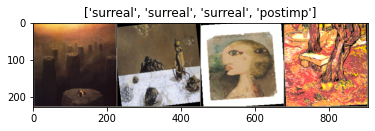

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    #plt.figure()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def plot_lines(list1, list2, plot_type, num_epoch):
  x1 = list(range(0, num_epoch))

  # line 1 points
  y1 = list(list1)
  # line 2 points
  y2 = list(list2)


  plt.figure(figsize=(14, 14), constrained_layout=False)
  # plotting the line 1 points
  plt.plot(x1, y1, label = "train")
  # plotting the line 2 points
  plt.plot(x1, y2, label = "validation")

  plt.xlabel("epochs")
  # Set the y axis label of the current axis.
  plt.ylabel(plot_type)
  # Set a title of the current axes.
  plt.title(f"{plot_type} graph for train and validation")
  # show a legend on the plot
  plt.legend()
  # Display a figure.
  plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lowest_epoch_loss = 100.0
    all_train_acc = []
    all_train_loss = []
    all_val_acc = []
    all_val_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                all_train_acc.append(epoch_acc)
                all_train_loss.append(epoch_loss)
            if phase == 'val':
                all_val_acc.append(epoch_acc)
                all_val_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            #if phase == 'val' and epoch_acc > best_acc:
            #    best_acc = epoch_acc
            #    best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                if (epoch_acc > best_acc or
                    (epoch_acc == best_acc and epoch_loss < lowest_epoch_loss)):
                    best_acc = epoch_acc
                    lowest_epoch_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Lowest Loss for highest Acc: {:4f}'.format(lowest_epoch_loss))


    try:
        plot_lines(all_train_acc, all_val_acc, "Accuracy", num_epochs)
        plot_lines(all_train_loss, all_val_loss, "Loss", num_epochs)
    except:
        pass

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6, loader_type="val"):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    if loader_type != "val" and loader_type != "test":
      print(f"Loader type '{loader_type}' is not defined. Use 'val' or 'test'")
      return

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[loader_type]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if class_names[preds[j]] == class_names[labels[j]]:
                  continue
                images_so_far += 1


                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                if class_names[preds[j]] == class_names[labels[j]]:
                  color = "green"
                else:
                  color = "red"

                ax.set_title(f'predicted: {class_names[preds[j]]} - actual: {class_names[labels[j]]}', color=color)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Sequential(
                nn.Linear(num_ftrs, 224),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(224, len(class_names)),
                nn.LogSoftmax(dim=1))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
#optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
#optimizer_ft = optim.Adamax(model_ft.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




Epoch 0/34
----------
train Loss: 1.1234 Acc: 0.4922
val Loss: 0.7470 Acc: 0.7125

Epoch 1/34
----------
train Loss: 0.8809 Acc: 0.6677
val Loss: 0.7105 Acc: 0.7125

Epoch 2/34
----------
train Loss: 0.7606 Acc: 0.7053
val Loss: 0.5736 Acc: 0.8125

Epoch 3/34
----------
train Loss: 0.6215 Acc: 0.7837
val Loss: 0.5498 Acc: 0.8250

Epoch 4/34
----------
train Loss: 0.6486 Acc: 0.7524
val Loss: 0.4999 Acc: 0.8500

Epoch 5/34
----------
train Loss: 0.5220 Acc: 0.8527
val Loss: 0.5866 Acc: 0.8375

Epoch 6/34
----------
train Loss: 0.3807 Acc: 0.8589
val Loss: 0.5222 Acc: 0.8000

Epoch 7/34
----------
train Loss: 0.3932 Acc: 0.8464
val Loss: 0.4141 Acc: 0.8750

Epoch 8/34
----------
train Loss: 0.3514 Acc: 0.8840
val Loss: 0.4248 Acc: 0.8750

Epoch 9/34
----------
train Loss: 0.3309 Acc: 0.8934
val Loss: 0.4018 Acc: 0.8875

Epoch 10/34
----------
train Loss: 0.3273 Acc: 0.9279
val Loss: 0.4849 Acc: 0.8125

Epoch 11/34
----------
train Loss: 0.2708 Acc: 0.9342
val Loss: 0.3908 Acc: 0.8750

Ep

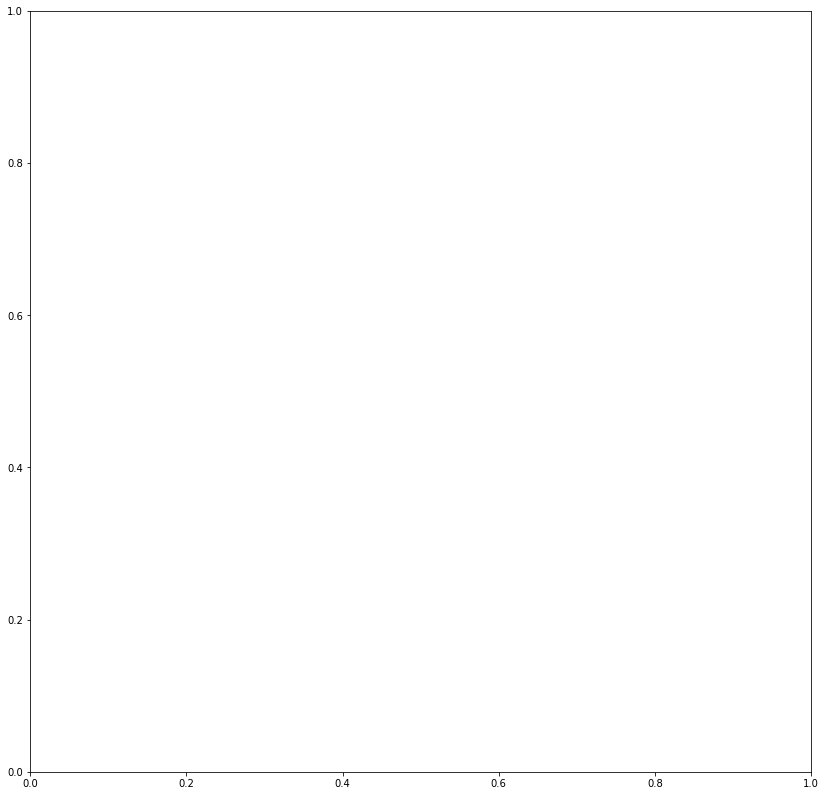

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=35)

In [ ]:
def test_model(model):
    was_training = model.training
    model.eval()
    images_so_far = 0
    label_scores = {}

    correct = 0
    false = 0
    num_images = len(image_datasets["test"])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                predicted = class_names[preds[j]]
                actual = class_names[labels[j]]

                if predicted == actual:
                  correct += 1
                  if actual in label_scores.keys():
                    label_scores[actual][0] += 1
                  else:
                    label_scores[actual] = [1, 0]
                else:
                  false += 1
                  if actual in label_scores.keys():
                    label_scores[actual][1] += 1
                  else:
                    label_scores[actual] = [0, 1]

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print(f"Correct: {correct}, False: {false}, Total: {num_images}")
                    for key,val in label_scores.items():
                      print(f"{key} -> Correct: {val[0]}, False: {val[1]}")
                    return
        model.train(mode=was_training)
        for key,val in label_scores.items():
          print(f"{key} -> Correct: {val[0]}, False: {val[1]}")

Correct: 72, False: 8, Total: 80
postimp -> Correct: 18, False: 2
baroque -> Correct: 18, False: 2
renaiss -> Correct: 17, False: 3
surreal -> Correct: 19, False: 1


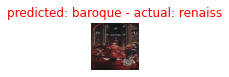

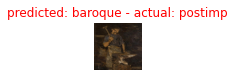

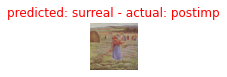

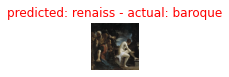

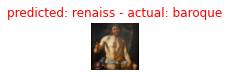

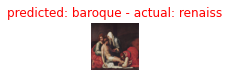

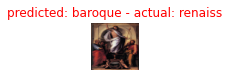

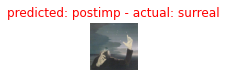

In [ ]:
test_model(model_conv)
visualize_model(model_conv, loader_type="test", num_images=8)
#visualize_model(model_ft, num_images=24)

In [ ]:
torch.save(model_ft, "model_ft34aw_4")
!mv ./model_ft34aw_4 ./drive/MyDrive/machineLearning

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
#https://discuss.pytorch.org/t/inject-dropout-into-resnet-or-any-other-network/66322/11
import torch.nn.functional as F

In [ ]:
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

#classifier?
#model_conv.classifier[6] = nn.Sequential(
#                nn.Linear(num_ftrs, 224),
#                nn.ReLU(),
#                nn.Dropout(0.4),
#                nn.Linear(224, len(class_names)),
#                nn.LogSoftmax(dim=1))

model_conv.fc = nn.Sequential(
                nn.Linear(num_ftrs, 224),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(224, len(class_names)),
                nn.LogSoftmax(dim=1))

#model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.0001, weight_decay=0.0001)
#optimizer_conv = optim.AdamW(model_conv.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
#optimizer_conv = optim.Adagrad(model_conv.parameters(), lr=0.0001)
optimizer_conv = optim.Adamax(model_conv.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for name, child in model_conv.named_children():
    print(name)
for name, child in model_conv.named_children():
    if name in ['layer3', 'layer4']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
              param.requires_grad = True
    else:
        for param in child.parameters():
              param.requires_grad = False

#optimizer_conv = optim.SGD(filter(lambda x: x.requires_grad, model_conv.parameters()), lr=0.001, momentum=0.9)
#optimizer_conv = optim.Adam(filter(lambda x: x.requires_grad, model_conv.parameters()), lr=0.0001, weight_decay=0.0001)
#optimizer_conv = optim.AdamW(filter(lambda x: x.requires_grad, model_conv.parameters()), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
#optimizer_conv = optim.Adagrad(filter(lambda x: x.requires_grad, model_conv.parameters()), lr=0.0001)
optimizer_conv = optim.Adamax(filter(lambda x: x.requires_grad, model_conv.parameters()), lr=0.0003, betas=(0.9, 0.999), eps=1e-08)


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
layer3 has been unfrozen.
layer4 has been unfrozen.


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




Epoch 0/29
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.1278 Acc: 0.4639


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


val Loss: 0.7303 Acc: 0.7500

Epoch 1/29
----------
train Loss: 0.8839 Acc: 0.6803
val Loss: 0.5919 Acc: 0.8250

Epoch 2/29
----------
train Loss: 0.7030 Acc: 0.7618
val Loss: 0.4782 Acc: 0.8000

Epoch 3/29
----------
train Loss: 0.5839 Acc: 0.8182
val Loss: 0.4439 Acc: 0.8500

Epoch 4/29
----------
train Loss: 0.5303 Acc: 0.8182
val Loss: 0.4875 Acc: 0.8375

Epoch 5/29
----------
train Loss: 0.5180 Acc: 0.8307
val Loss: 0.4181 Acc: 0.8375

Epoch 6/29
----------
train Loss: 0.4501 Acc: 0.8715
val Loss: 0.3807 Acc: 0.9000

Epoch 7/29
----------
train Loss: 0.3871 Acc: 0.9060
val Loss: 0.4771 Acc: 0.8625

Epoch 8/29
----------
train Loss: 0.5190 Acc: 0.8464
val Loss: 0.5015 Acc: 0.8500

Epoch 9/29
----------
train Loss: 0.4228 Acc: 0.8683
val Loss: 0.4157 Acc: 0.8625

Epoch 10/29
----------
train Loss: 0.3737 Acc: 0.9028
val Loss: 0.3863 Acc: 0.9125

Epoch 11/29
----------
train Loss: 0.2889 Acc: 0.9498
val Loss: 0.3694 Acc: 0.8875

Epoch 12/29
----------
train Loss: 0.3847 Acc: 0.8934
v

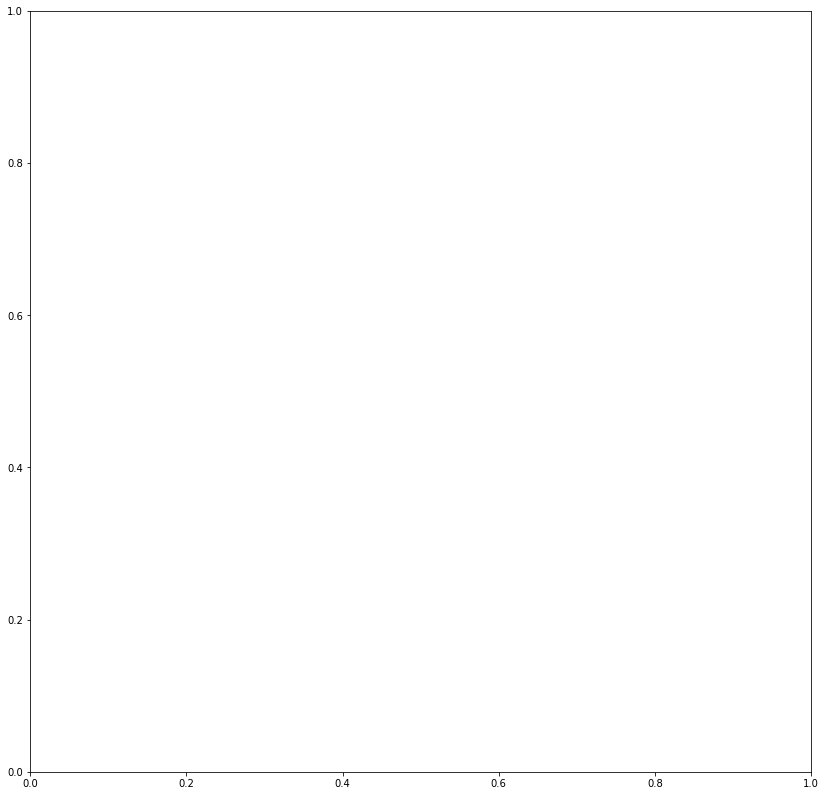

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

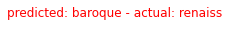

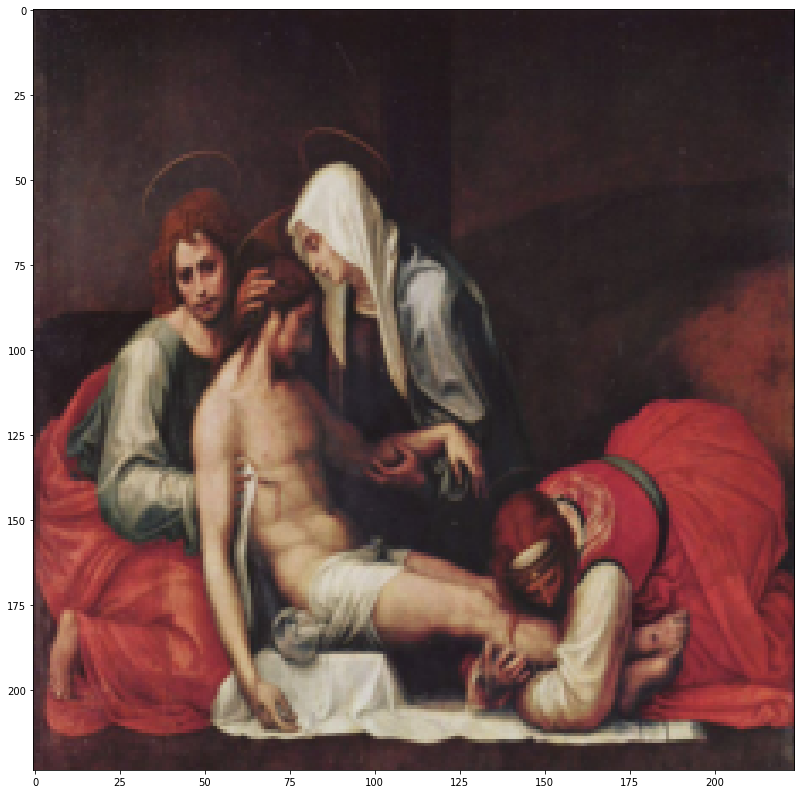

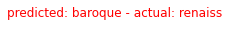

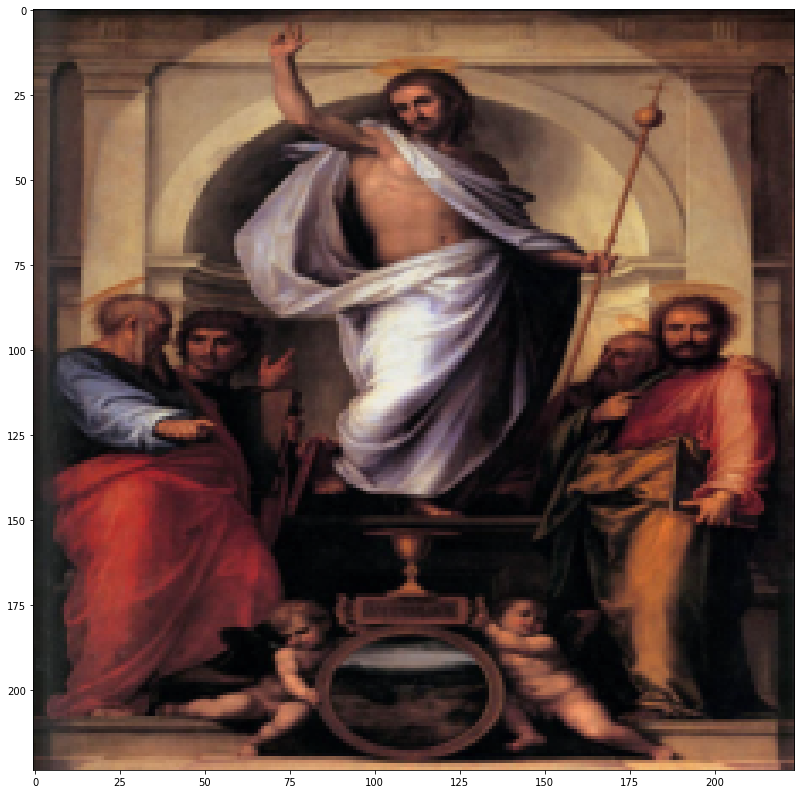

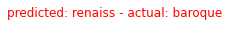

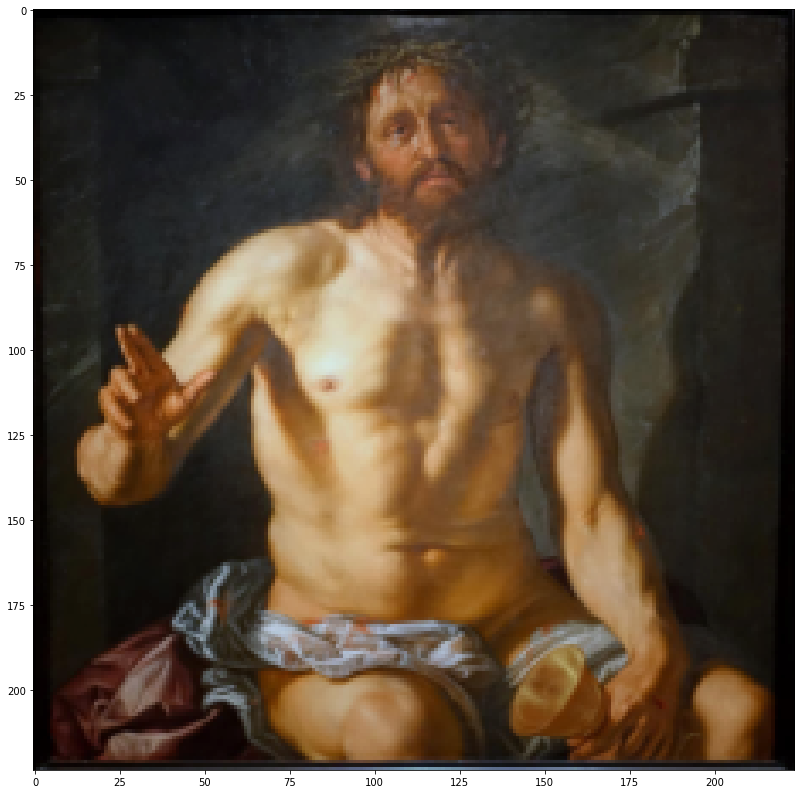

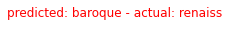

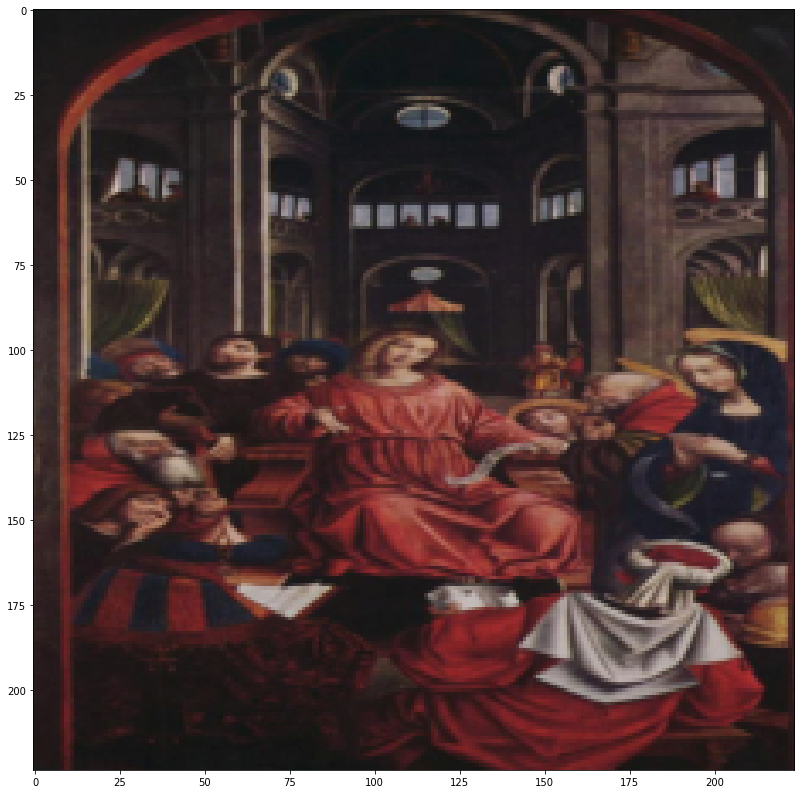

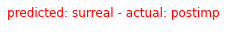

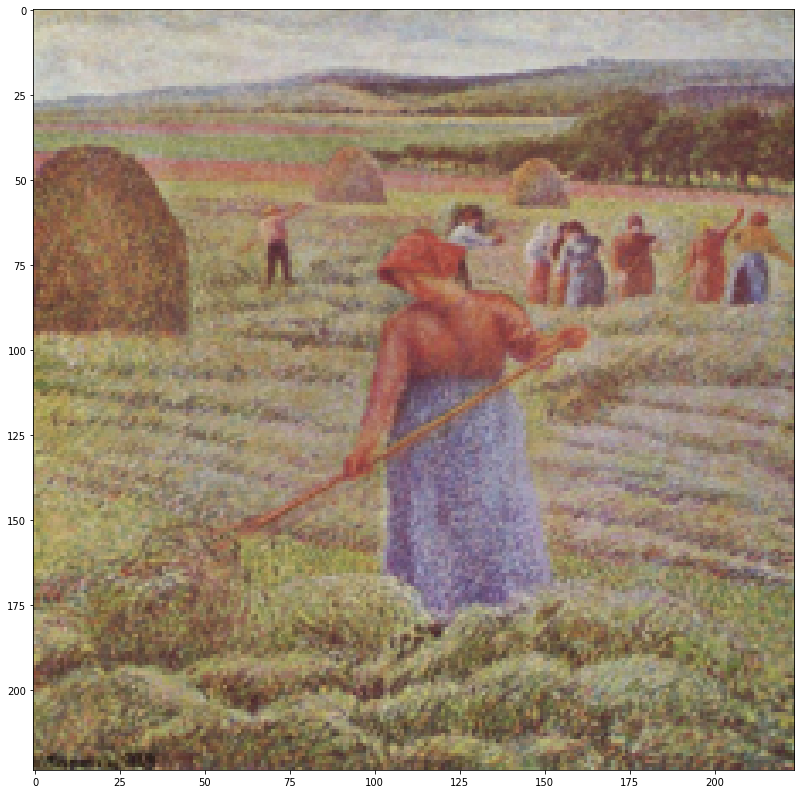

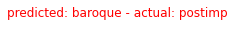

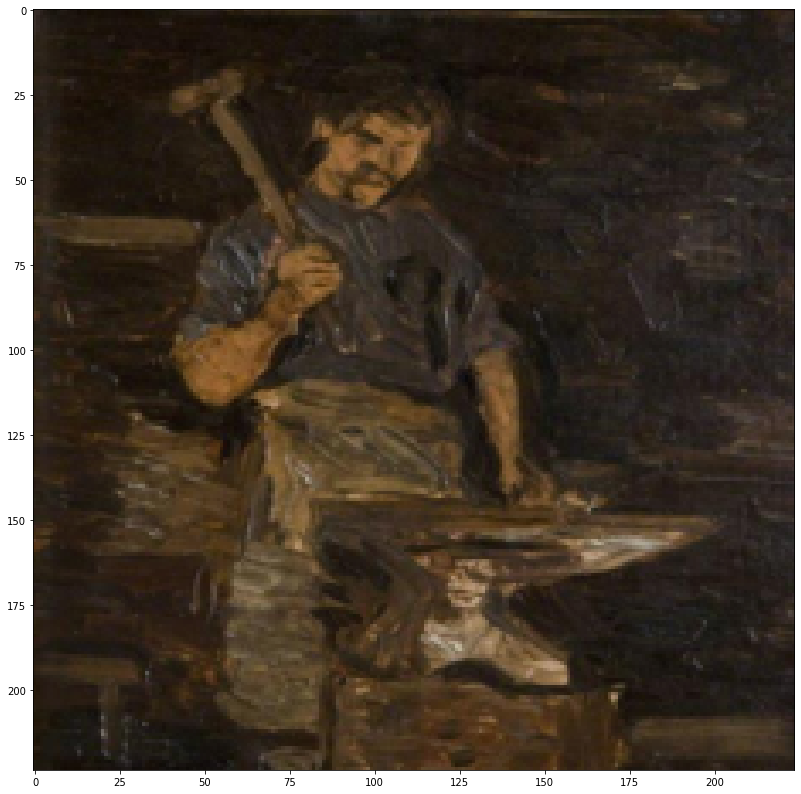

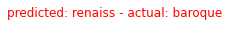

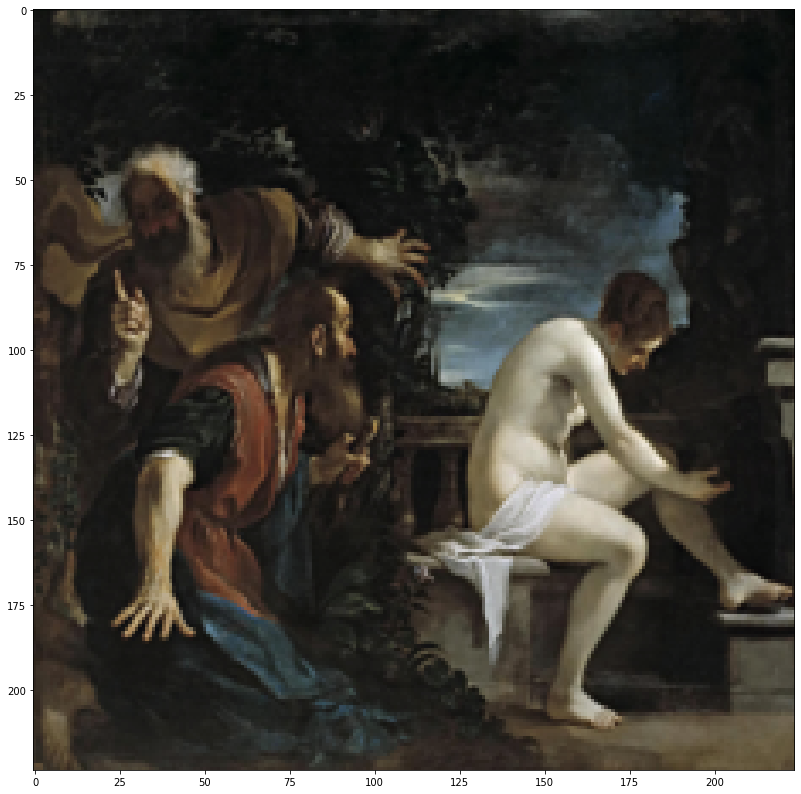

Correct: 53, False: 7, Total: 60
baroque -> Correct: 18, False: 2
renaiss -> Correct: 17, False: 3
postimp -> Correct: 18, False: 2


In [ ]:
visualize_model(model_conv, num_images=24, loader_type="test")

plt.ioff()
plt.show()
test_model(model_conv)

In [ ]:
torch.save(model_conv, "model_conv34aw_5")

In [ ]:
!cp ./model_conv34aw_5 ./drive/MyDrive/machineLearning/

## Test With Input

In [ ]:
#Get model from Drive
!cp drive/MyDrive/machineLearning/model_conv34amax2_4 ./

In [ ]:
model_conv = torch.load("./model_conv34amax2_4")

In [ ]:
!cp drive/MyDrive/machineLearning/newtest500.zip ./

In [ ]:
!unzip "newtest500.zip"

In [ ]:
!mkdir ./data/test

In [ ]:
!mv ./newtest/surreal ./data/test/
!mv ./newtest/baroque ./data/test/
!mv ./newtest/renaiss ./data/test/
!mv ./newtest/postimp ./data/test/

In [ ]:
!rmdir ./newtest

In [ ]:
!mv ./newtest/express ./data/test/

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



